# Ultra-High-Density Recording Explorer (Experimental Data)

- Reads in an h5 file from Lead Labs Willow System (or anything that saves data as h5 files)
- Filters the data between 400 and 9500 Hz (in vivo recordings)
- Determines baseline noise levels in both the filtered and unfiltered traces
- Displays raw traces from each channel as they are arranged on the probe shank

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = 'experiment_C20200330-175336.h5'
fs = 30000
window = [0, 60] # in seconds. 4 mins is the max on an i7 8 core processor with 16GB RAM
chan_num = [0,64]
col_num = 3 # columns per shank
row_num = [22,20,22] # rows per column (# values should == # columns)

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd

## Read in the Multichannel Data
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working
 
#### Experimental data

In [3]:
channels = list(range(chan_num[0],chan_num[1]))
f_data = h5py.File(datafile, 'r')
xs = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data')  # actual data in microvolts (y)
xs = xs[window[0]*fs:window[1]*fs]
ys = ys[window[0]*fs:window[1]*fs, channels] * 0.195 # Remove unconnected channels (based on impedence data)
display (HTML("<hr><h4>Data consists of " + str(ys.shape[1]) + 
              " columns of data (channels, x) and " + str(ys.shape[0]) + 
              " rows of data (measurements, y)." + "The recording is " +
              str(round(ys.shape[0]/(fs * 60),3)) + " mins long. <hr>"))

## Bandpass Filter (butterworth) of Experimental Data
- Have to analyze a subset of channels at a time or you get dead kernels
- 64 channels at a time works well (1 shank)

In [4]:
from scipy.signal import butter, sosfiltfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

def get_filtered (start_chan, end_chan, df):
    lowcut = 400
    highcut = 5000
    display (HTML("<h4>Analyzing channel: "))
    for chan in list(range(start_chan,end_chan)):
        print(chan, end = ' ')
        order = 6
        x = np.arange(len(ys[:,chan]))
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = sosfreqz(sos, worN=2000)
        filtered[chan] = butter_bandpass_filter(ys[:,chan], lowcut, highcut, fs, order=order)
    return df

filtered = pd.DataFrame()
filtered = get_filtered(chan_num[0], chan_num[1], filtered)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Analyze noise of unfiltered experimental data

In [5]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(ys[0:30000, chan]))
    medians.append(np.median(ys[0:30000, chan]))
    sds.append(np.std(ys[0:30000, chan]))
    rngs.append(np.ptp(ys[0:30000, chan]))

unfiltered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(unfiltered_stats.head().to_html()))

,means,medians,sds,rngs
0,6399.518359,6392.100,123.447239,1018.290
1,6400.078666,6396.390,114.159562,975.780
2,6397.838473,6387.810,136.880774,1419.795
3,6398.058453,6396.195,124.337490,1023.750
4,6399.920664,6394.440,119.891008,1032.915


## Analyze noise of filtered experiment

In [6]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(filtered.iloc[0:30000, chan]))
    medians.append(np.median(filtered.iloc[0:30000, chan]))
    sds.append(np.std(filtered.iloc[0:30000, chan]))
    rngs.append(np.ptp(filtered.iloc[0:30000, chan]))

filtered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(filtered_stats.head().to_html()))

,means,medians,sds,rngs
0,-0.010103,-0.428165,50.146673,740.860510
1,-0.012471,0.566301,45.555771,504.181118
2,0.004572,-1.763404,49.535605,611.256443
3,0.001528,1.633728,50.441397,534.919369
4,-0.005854,0.128274,48.141641,589.875436


## Save the filtered (64 channels) and noise stats to a new file
- This will make it easier to fetch the data later on without having to reload the whole thing
- This takes about 5-15 minutes per file

In [7]:
# Add datasets to h5 file: impedance, median imp, range, 25th and 75th percentiles, mean noise from sub,
# potential bad channels filtered traces
hf = h5py.File(datafile.replace('.h5', '_filtered_' + str(chan_num[1]) + '.h5'), 'w')
hf.create_dataset('sample_index', data = list(range(0,len(filtered.iloc[:,0]))))
hf.create_dataset('channel_data', data = filtered)
hf.create_dataset('filtered_stats', data = filtered_stats)
hf.create_dataset('unfiltered_stats', data = unfiltered_stats)
hf.close()

## Plot 2 mins of a single channel
- useful for finding regions of activity quickly

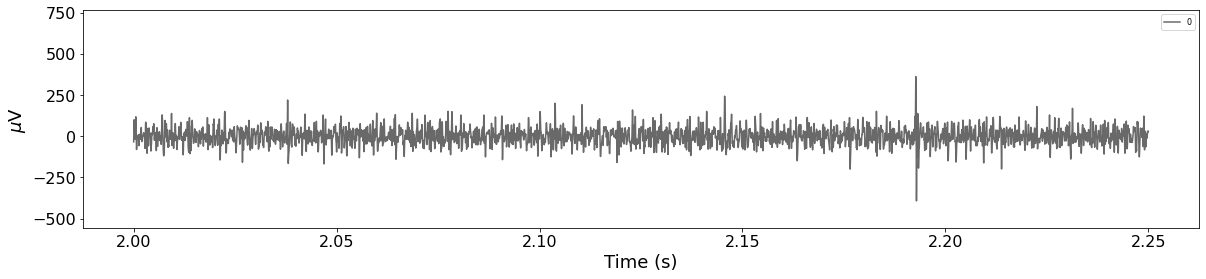

In [14]:
def single_plot(chan, start, end):
    start = int(start * fs)
    end = int(end * fs)
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (figsize =(20,4))
    ax.plot(xs[start:end]/fs, filtered.iloc[start:end,chan], color = 'dimgray', 
                            label=str(chan))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
    ax.set_ylim(filtered_stats.means[chan] - filtered_stats.rngs[chan]*0.75, 
                              filtered_stats.means[chan] + unfiltered_stats.rngs[chan]*0.75)
    ax.set_ylabel(r'$\mu$V', fontsize = 18)
    ax.set_xlabel('Time (s)', fontsize = 18)
    ax.tick_params(labelsize = 16)
    

single_plot(0, 2, 2.25) # in seconds

## Plot unfiltered experimental data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

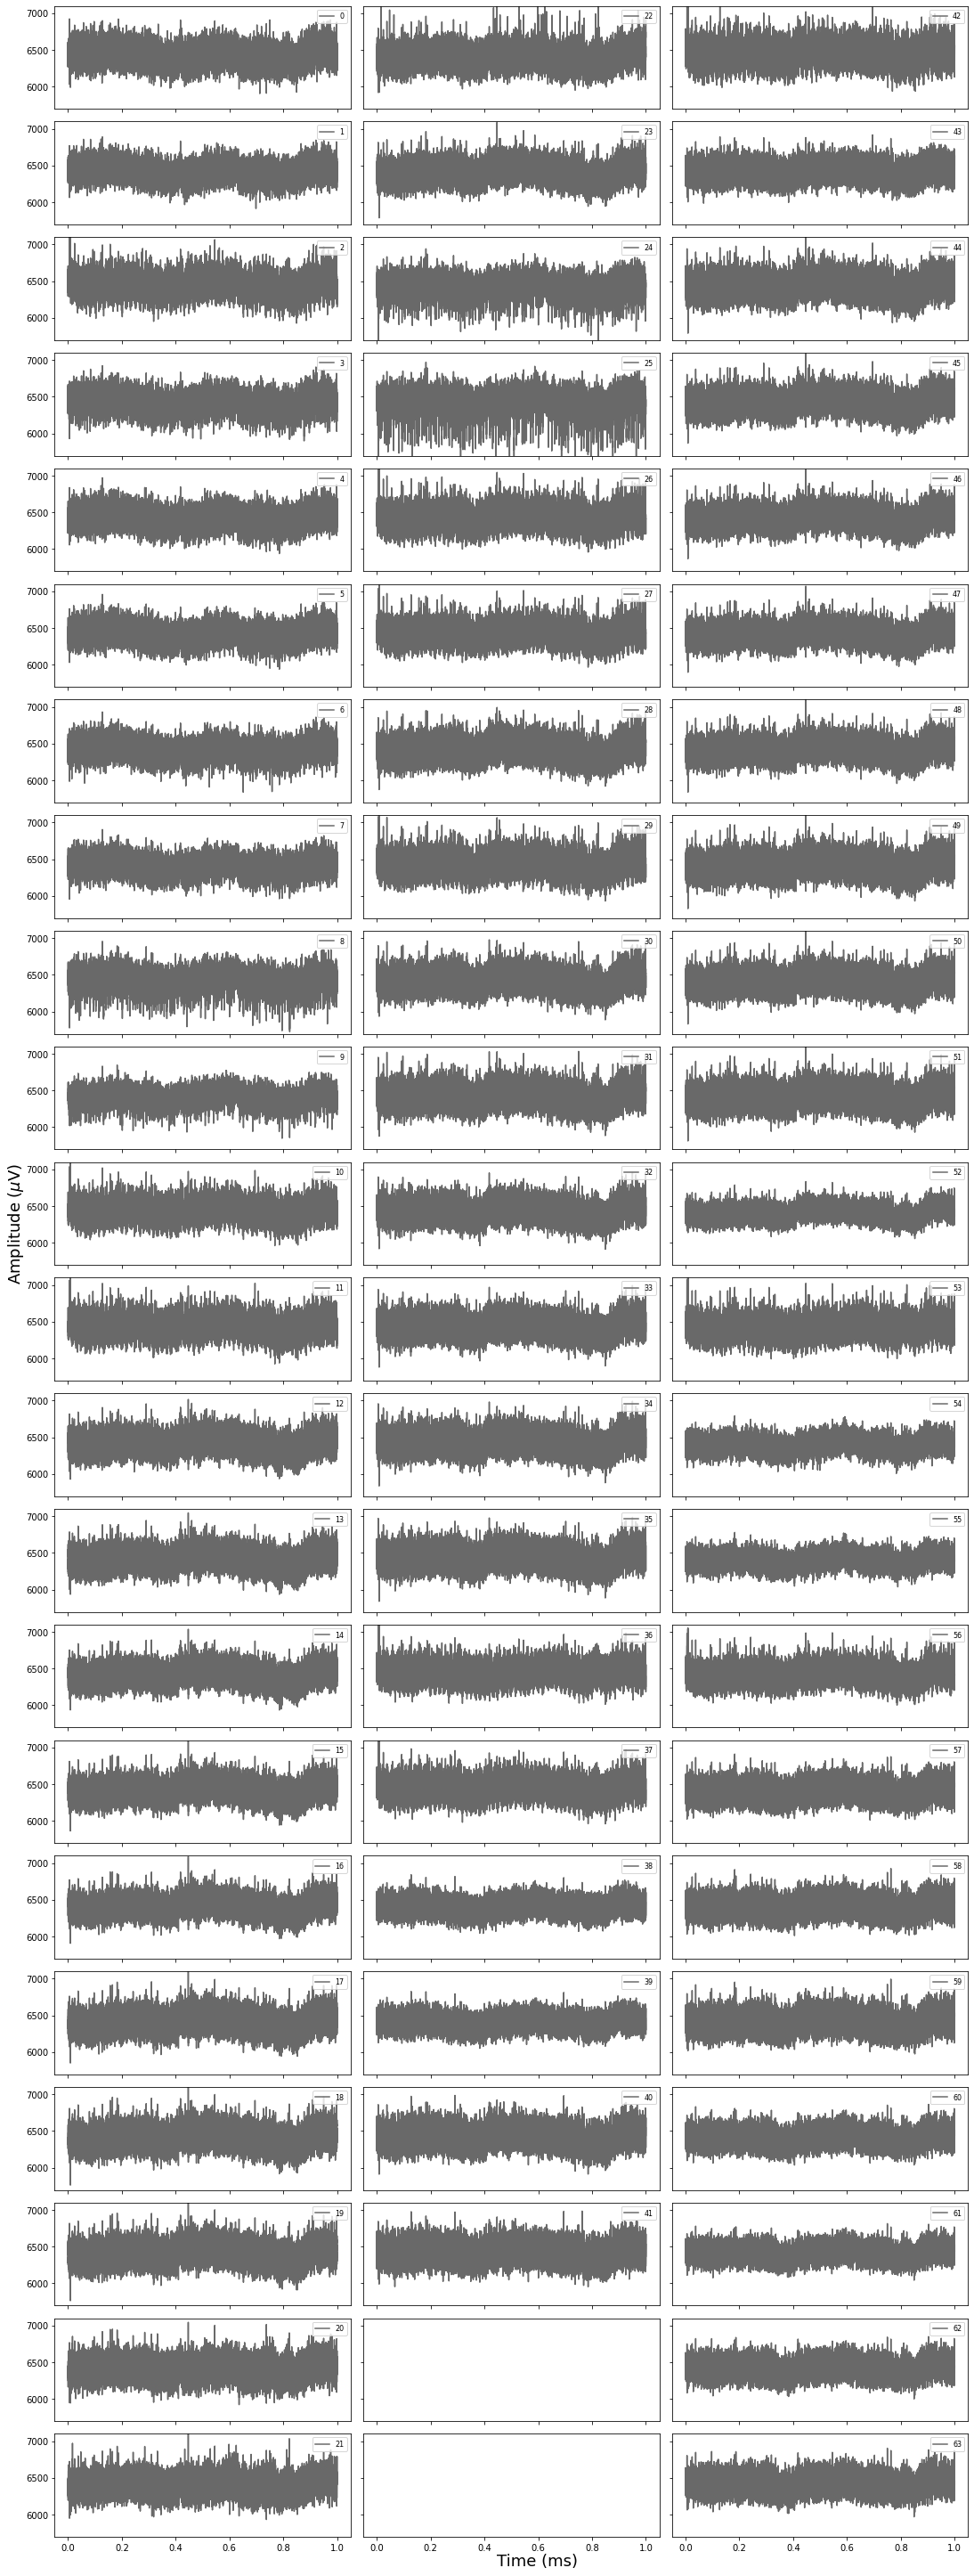

In [9]:
def grid_plot_unfiltered(chans, start, end):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (max(row_num),len(row_num), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    ch_num = 0
    for j in range (0,col_num):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, ys[start:end,ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Unfiltered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            #y_lims = ax[i][j].get_ylim()
            #ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(unfiltered_stats.means[ch_num] - unfiltered_stats.rngs[ch_num]*0.75, 
                              unfiltered_stats.means[ch_num] + unfiltered_stats.rngs[ch_num]*0.75)
            #ax[i][j].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
            #ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig (datafile.replace('.h5','_unfiltered' + str(chan_num[1]) + '.png'))
    display(HTML('<hr>'))


win = [0,30000] 
chans = list(np.arange(0,col_num + sum(row_num)))
grid_plot_unfiltered(chans, win[0], win[1])

## Plot filtered experimental data as grid

In [ ]:
def grid_plot_filtered(chans, start, end):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (max(row_num),len(row_num), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    ch_num = 0
    for j in range (0,col_num):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, filtered.iloc[start:end,ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            ax[i][j].set_ylim(filtered_stats.means[ch_num] - filtered_stats.rngs[ch_num]*0.75, 
                              filtered_stats.means[ch_num] + filtered_stats.rngs[ch_num]*0.75)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig (datafile.replace('.h5','_filtered_' + str(chan_num[1]) + '.png'))
    display(HTML('<hr>'))


win = [0,30000] 
chans = list(np.arange(0,col_num + sum(row_num)))
grid_plot_filtered(chans, win[0], win[1])